In [3]:
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Flatten, ZeroPadding2D, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
import h5py
import os
import cv2
import csv
import math
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


In [4]:
vgg16_model = keras.applications.vgg16.VGG16(weights='Z:/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

In [5]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
model = Sequential()

for layer in vgg16_model.layers[:-3]:
    
    model.add(layer)
    
for layer in model.layers:
    
    layer.trainable = True

In [7]:
#model.add(Dropout(0.10))
model.add(Dense(1000,activation='relu'))
model.add(Dense(700,activation='relu'))
model.add(Dense(5,activation='relu'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [9]:
model.load_weights('Z:/JupyterNotebooks/VGG16_smoke_best_700(26.03).h5')
print('Loading Complete')

Loading Complete


In [10]:
from keras.utils import Sequence

train_images_path = 'Z:/Smoke_Dataset_3/Train/'
valid_images_path = 'Z:/Smoke_Dataset_3/Valid/'
train_CSV_file = 'Z:/Smoke_Dataset_3/Train_shuffled.csv'
valid_CSV_file = 'Z:/Smoke_Dataset_3/Valid_shuffled.csv'
img_size = 224

class DataGenerator(Sequence):
    
    def __init__(self,csv_file,img_path,num,batch_size=25):
        
        self.csv_file = csv_file
        self.x = []
        self.y = np.zeros((int(num),5))
        self.batch_size = batch_size
        self.length = 0
        
        with open(self.csv_file,"r") as csv_data:
            csv_reader = csv.reader(csv_data, delimiter=',')
            line_no = 0
            
            for row in csv_reader:
                if line_no != 0:
                    
                    w = int(row[1])
                    h = int(row[2])
                    c = int(row[3])
                    minx = abs(int(row[4]))
                    miny = abs(int(row[5]))
                    maxx = abs(int(row[6]))
                    maxy = abs(int(row[7]))
                    
                    self.y[line_no-1][0] = int(c)
                    self.y[line_no-1][1] = (minx/w)*img_size
                    self.y[line_no-1][2] = (miny/h)*img_size
                    self.y[line_no-1][3] = (maxx/w)*img_size
                    self.y[line_no-1][4] = (maxy/h)*img_size
                    
                    #self.y.append([minx,miny,maxx,maxy])
                    self.x.append(img_path + row[0])
                    line_no += 1
                    
                else:
                    line_no += 1
        self.length = (math.ceil(len(self.x) / self.batch_size))
        #print(len(self.x),self.length)
        #print(self.y)
                    
    def __loadimages(self,batch):
            
        img = []
            
        for filename in batch:
                
            im = cv2.resize(cv2.imread(filename), (img_size, img_size))
            img.append(im)
                
        return np.array(img)
            
    def __len__(self):
        return self.length
                
    def __getitem__(self,idx):
            
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
            
        images = self.__loadimages(batch_x).astype('float32')
            
        return images,batch_y
            
        
        
        

In [11]:
train_datagen = DataGenerator(train_CSV_file,train_images_path,1158,32)
valid_datagen = DataGenerator(valid_CSV_file,valid_images_path,140,25)

In [12]:

checkpoint = keras.callbacks.ModelCheckpoint("VGG16_0.0005_smokeLoc3-{loss:.3f}.h5", 
                             monitor="loss", 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=True, 
                             mode="auto", 
                             period=1)

model.compile(loss=keras.losses.mean_squared_logarithmic_error, 
              optimizer=keras.optimizers.SGD(lr=0.0005), 
              metrics=["accuracy"])


In [38]:
model.evaluate_generator(valid_datagen,steps=1,verbose=1)
model.evaluate_generator(train_datagen,steps=37,verbose=1)

37/37 [==============================] - 105s 3s/step


[0.24403470867861943, 0.8480138169257341]

In [31]:
history = model.fit_generator(train_datagen, 
                    steps_per_epoch=37, 
                    epochs=5, 
                    validation_data=valid_datagen,
                    validation_steps=6,
                    callbacks=[checkpoint])

Epoch 1/5
37/37 [==============================] - 92s 2s/step - loss: 0.2495 - acc: 0.8230 - val_loss: 1.8371 - val_acc: 0.6071

Epoch 00001: loss improved from inf to 0.22721, saving model to VGG16_0.0005_smokeLoc3-0.227.h5
Epoch 2/5
37/37 [==============================] - 77s 2s/step - loss: 0.2229 - acc: 0.8247 - val_loss: 1.8904 - val_acc: 0.6214

Epoch 00002: loss improved from 0.22721 to 0.22459, saving model to VGG16_0.0005_smokeLoc3-0.225.h5
Epoch 3/5
37/37 [==============================] - 77s 2s/step - loss: 0.2189 - acc: 0.8308 - val_loss: 1.8532 - val_acc: 0.6214

Epoch 00003: loss improved from 0.22459 to 0.22137, saving model to VGG16_0.0005_smokeLoc3-0.221.h5
Epoch 4/5
37/37 [==============================] - 77s 2s/step - loss: 0.2198 - acc: 0.8283 - val_loss: 1.8439 - val_acc: 0.6143

Epoch 00004: loss did not improve from 0.22137
Epoch 5/5
37/37 [==============================] - 77s 2s/step - loss: 0.2233 - acc: 0.8272 - val_loss: 1.8257 - val_acc: 0.6286

Epoch 0

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


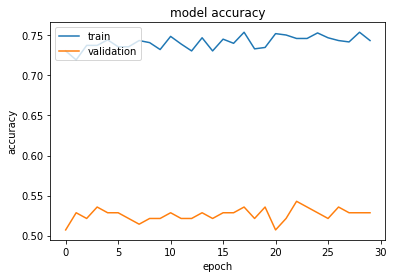

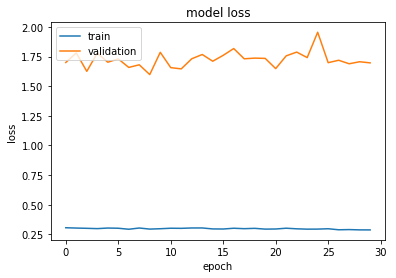

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [14]:
#model.load_weights('Z:/JupyterNotebooks/VGG16_smokeLoc2-0.22.h5')
#print('Loading Complete')

#model.evaluate_generator(valid_datagen,steps=1,verbose=1)
#model.evaluate_generator(train_datagen,steps=1,verbose=1)

1/1 [==============================] - 3s 3s/step
[[  0.         55.525085   84.85176   230.4734    232.94879  ]
 [  0.          0.          1.3969767   2.0380232   0.       ]
 [  0.          2.9018805  30.935955  139.22346   180.40265  ]
 [  0.         88.64103   115.144936  202.28722   186.16812  ]
 [  0.          6.7583084  32.644543   91.94606    99.41266  ]
 [  0.         73.617      28.013142  209.95946   183.33096  ]
 [  8.322409    0.          0.          0.          0.       ]
 [  0.         28.334396   21.47762   101.61734    94.074326 ]
 [  0.         17.405136   80.62789   147.70549   168.67636  ]
 [  0.          0.          0.          0.          0.       ]
 [  0.         41.58901     0.        119.91937   178.78604  ]
 [  0.          0.          0.          0.          0.       ]
 [  0.         11.683626    6.436374  138.14915   158.4868   ]
 [  0.        112.17933    83.39642   197.98512   206.79268  ]
 [  0.         87.28066   111.93823   186.54814   181.0058   ]
 [  0

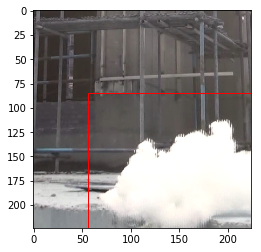

1 Class : 0.0
[0.        0.        1.3969767 2.0380232 0.       ]


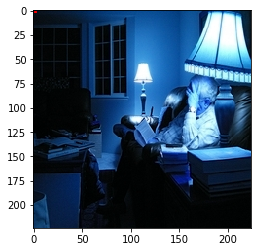

2 Class : 0.0
[  0.          2.9018805  30.935955  139.22346   180.40265  ]


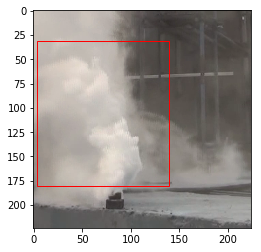

3 Class : 0.0
[  0.        88.64103  115.144936 202.28722  186.16812 ]


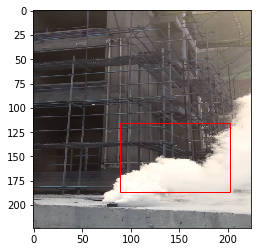

4 Class : 0.0
[ 0.         6.7583084 32.644543  91.94606   99.41266  ]


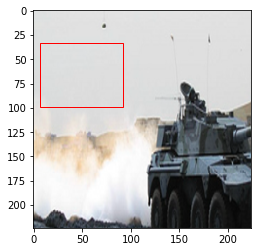

5 Class : 0.0
[  0.        73.617     28.013142 209.95946  183.33096 ]


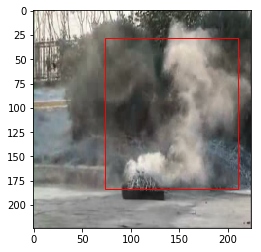

6 Class : 0.0
[8.322409 0.       0.       0.       0.      ]


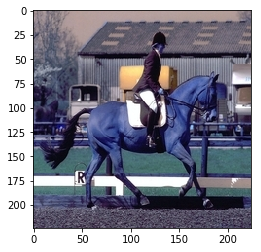

7 Class : 0.0
[  0.        28.334396  21.47762  101.61734   94.074326]


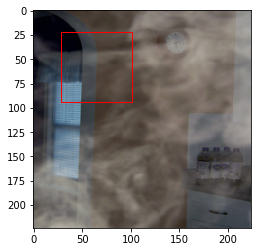

8 Class : 0.0
[  0.        17.405136  80.62789  147.70549  168.67636 ]


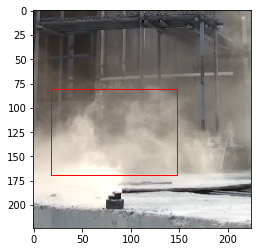

9 Class : 0.0
[0. 0. 0. 0. 0.]


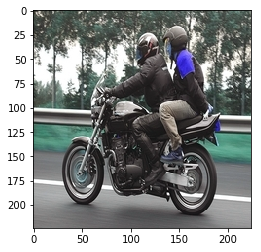

10 Class : 0.0
[  0.       41.58901   0.      119.91937 178.78604]


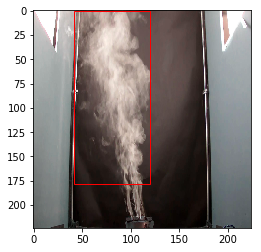

11 Class : 0.0
[0. 0. 0. 0. 0.]


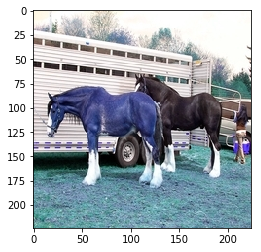

12 Class : 0.0
[  0.        11.683626   6.436374 138.14915  158.4868  ]


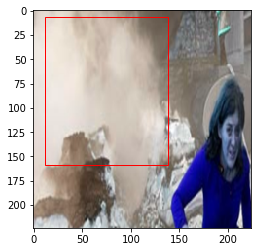

13 Class : 0.0
[  0.      112.17933  83.39642 197.98512 206.79268]


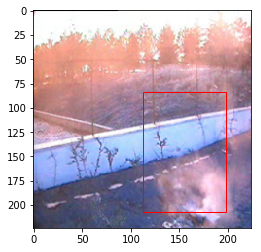

14 Class : 0.0
[  0.       87.28066 111.93823 186.54814 181.0058 ]


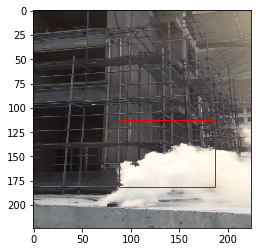

15 Class : 0.0
[  0.        0.        0.      195.3402  204.26242]


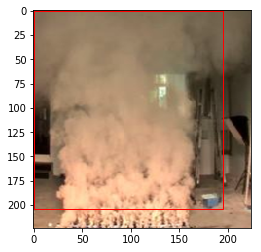

16 Class : 0.0
[ 0.        9.967796  8.258454 30.542284 49.145798]


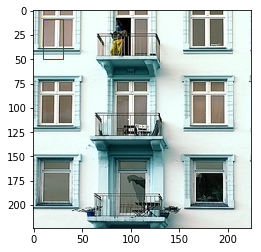

17 Class : 0.0
[  0.        28.799404   0.       169.84016  155.99033 ]


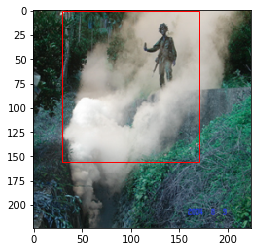

18 Class : 0.0
[  0.        32.90547   17.748888 123.127365 138.4718  ]


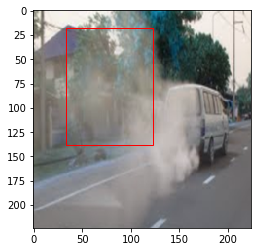

19 Class : 0.0
[  0.       94.36173 152.78258 162.71208 200.00186]


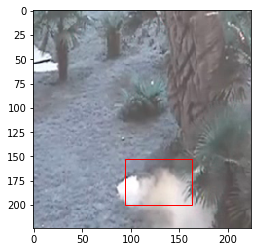

20 Class : 0.0
[  0.        20.520687  39.677914 144.17226  163.47485 ]


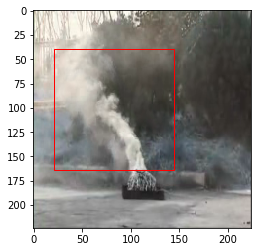

21 Class : 0.0
[0. 0. 0. 0. 0.]


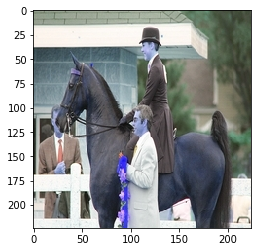

22 Class : 0.0
[0. 0. 0. 0. 0.]


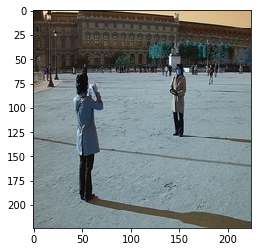

23 Class : 0.0
[  0.        85.16402   34.289215 176.47595  166.81229 ]


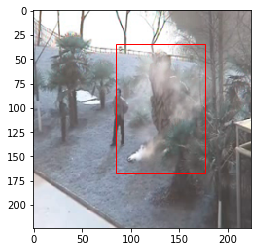

24 Class : 0.0
[ 0.         3.193859   3.1230345 13.568692  31.342731 ]


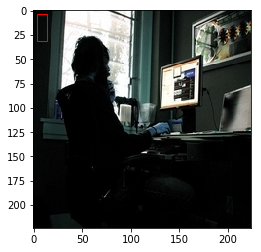

25 Class : 0.0


IndexError: index 25 is out of bounds for axis 0 with size 25

In [40]:
pred_array = model.predict_generator(valid_datagen, steps=1, verbose=1)

print(pred_array)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
count = 0

for img,label in valid_datagen:
    
    for im in img:
        
        print(str(count) + " Class : " + str(pred_array[0][0]))
        print(pred_array[count])
        xm,ym = pred_array[count][1],pred_array[count][2]
        wt = (pred_array[count][3] - pred_array[count][1])
        ht = (pred_array[count][4] - pred_array[count][2])
        im = np.array(img[count],dtype=np.uint8)
        fig,ax = plt.subplots(1)
        ax.imshow(im)
        rect = patches.Rectangle((xm,ym),wt,ht,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show()
        fig.savefig('Z:/pred_outputs/pred_' + str(count) + '.png')
        count += 1

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
count = 0

for img,label in train_datagen:
    
    for lab in label:
        
        print(lab)
        count += 1
        if count>100 : break


[  1.          88.2         37.33333333 116.2        124.13333333]
[  1.          93.56666667  52.47407407 121.56666667 115.52592593]
[  1.          61.6          3.73333333 117.6        211.14074074]
[  1.          91.35        83.37777778 119.81666667 141.65925926]
[  1.     67.375 163.625 134.75  216.125]
[  1.          72.91666667  35.67407407 130.08333333 200.14814815]
[  1.           1.63333333  11.40740741  65.68333333 122.16296296]
[  1.    121.625 112.    152.25  145.25 ]
[  1.          62.88958991   2.11820331 219.40694006  89.49408983]
[  1.           0.           0.         224.         189.46666667]
[  1.          64.75        57.86666667 122.15       190.81481481]
[0. 0. 0. 0. 0.]
[  1.      0.875 128.625 124.25  219.625]
[  1.          63.35        67.40740741  89.01666667 150.78518519]
[  1.         151.61481481  15.55555556 216.94814815 143.42222222]
[  1.          66.03333333  27.79259259 195.76666667 179.2       ]
[  1.          79.1         58.28148148 155.28333333 